In [9]:
import xarray as xr
import cartopy
from geopy.geocoders import Nominatim
import re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

import geopandas as gpd

In [3]:
def decode_times(ts):
    
    # Method to manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in range(len(ts.time))]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(ts.time))]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts



def get_latlon(city):
    
    # retrieve lat & lon for given location
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}


In [4]:
# import sys; sys.path.append('/home/clair/wwa'); from wwa import *
cproj = cartopy.crs.PlateCarree()
sp = get_latlon("Sao Paolo, BR")

### **Convert time series to csv for easier loading into R**

In [16]:
ts_era5 = decode_times(xr.open_dataset("data/tuploaded43.nc", decode_times = False)).temperature
ts_era5 = ts_era5.assign_coords(time = ts_era5.time.dt.year).rename("tmax", time = "year")
ts_era5.to_dataframe().to_csv("ts/era5_tx10day.csv")

## **Correlations between Nino3.4rel and ERA5 - per month**

In [24]:
nino = decode_times(xr.open_dataset("data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].resample(time = "MS").mean()
nino = nino.sel(time = slice("1950", "2023-08"))

era5 = decode_times(xr.open_dataset("data/era5_tmax_daily_extended_-90--30E_-60-20N_12_mean_0.nc", decode_times=False)).tmax
era5 = era5.sel(time = slice(None, "2023-08"))

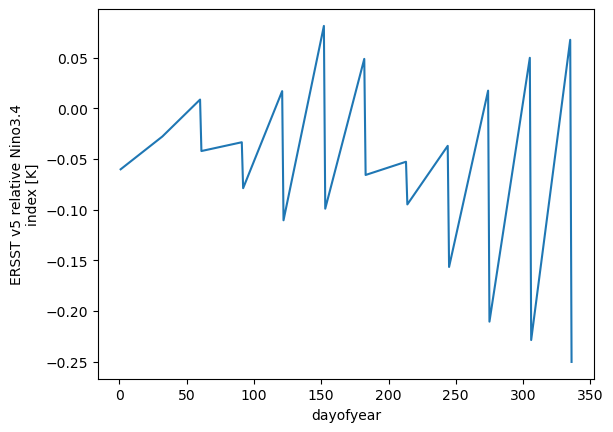

In [28]:
nino.groupby("time.dayofyear").mean().plot()

In [16]:
era5_corr = []
for m in range(1,13):
    nino_m = nino.groupby("time.month")[m]
    era5_m = era5.groupby("time.month")[m]
    
    corr_m = xr.apply_ufunc(lambda ts : np.corrcoef(nino_m.values, ts)[0,1], era5_m, input_core_dims = [["time"]], vectorize = True)
    era5_corr.append(corr_m.expand_dims(month = [m]))
era5_corr = xr.concat(era5_corr, "month")

sp = get_latlon("Sao Paolo, BR")


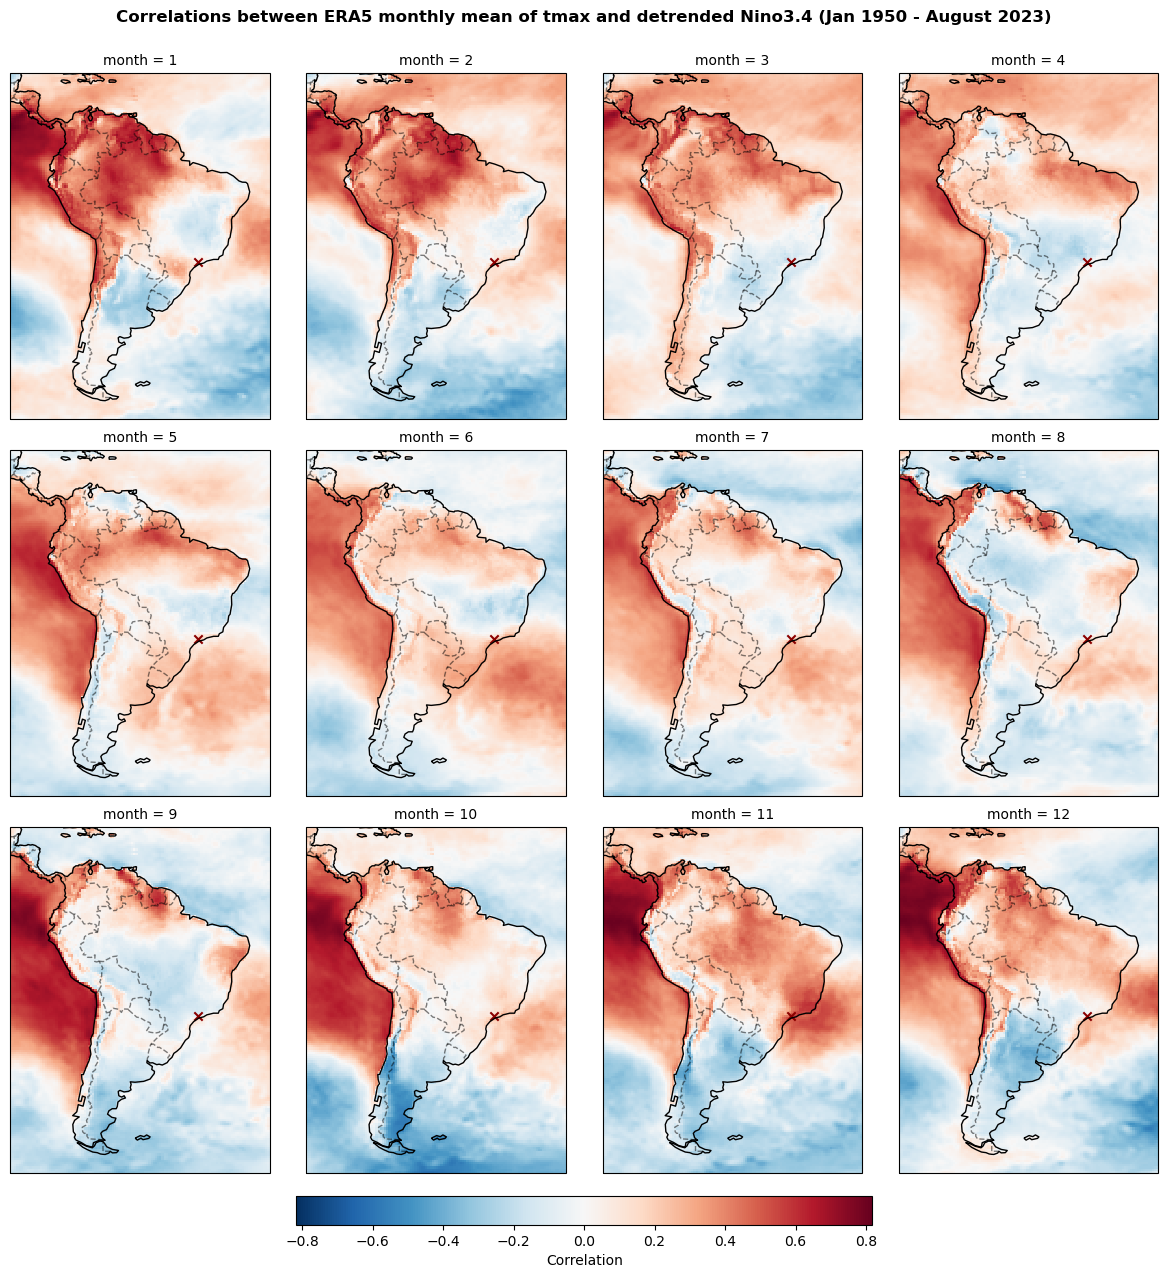

In [17]:
era5_corr.plot(col = "month", col_wrap = 4, figsize = (12,12), subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
              cbar_kwargs = {"fraction" : 0.025, "pad" : 0.02, "label" : "Correlation", "location" : "bottom"})

for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    ax.scatter(*sp.values(), marker = "x", color = "darkred")
    
plt.suptitle("Correlations between ERA5 monthly mean of tmax and detrended Nino3.4 (Jan 1950 - August 2023)", y = 1.025, fontweight = "bold")
plt.savefig("fig/corr_nino34rel-era5_SouthAmerica.png")

## **Correlations between Nino3.4det and ERA5**

In [29]:
era5 = decode_times(xr.open_dataset("data/era5_tmax_daily_extended_-90--30E_-60-20N_12_mean_0.nc", decode_times=False)).tmax
era5 = era5.sel(time = slice(None, "2023-08"))

nino = decode_times(xr.open_dataset("data/iersst_nino3.4a.nc", decode_times = False))["Nino3.4"]
sst2020 = decode_times(xr.open_dataset("data/iersstv5_0-360E_-20-20N_su_0-360E_-20-20N_n_su.nc", decode_times = False))["sst"]

nino_det = (nino - sst2020).dropna("time", "any").resample(time = "MS").mean().sel(time = slice("1950", "2023-08"))
nino_det = nino_det - nino_det.mean()

nino_det.to_dataframe(name = "nino3.4_det").to_csv("data/nino3.4_detrended.csv")

In [19]:
sondj = [m in [9,10,11,12,1] for m in nino_det.time.dt.month]

In [20]:
corr = xr.apply_ufunc(lambda ts : np.corrcoef(nino_det.values, ts)[0,1], era5, input_core_dims = [["time"]], vectorize = True)

In [21]:
corr_sondj = xr.apply_ufunc(lambda ts : np.corrcoef(nino_det.sel(time = sondj).values, ts)[0,1], era5.sel(time = sondj), input_core_dims = [["time"]], vectorize = True)

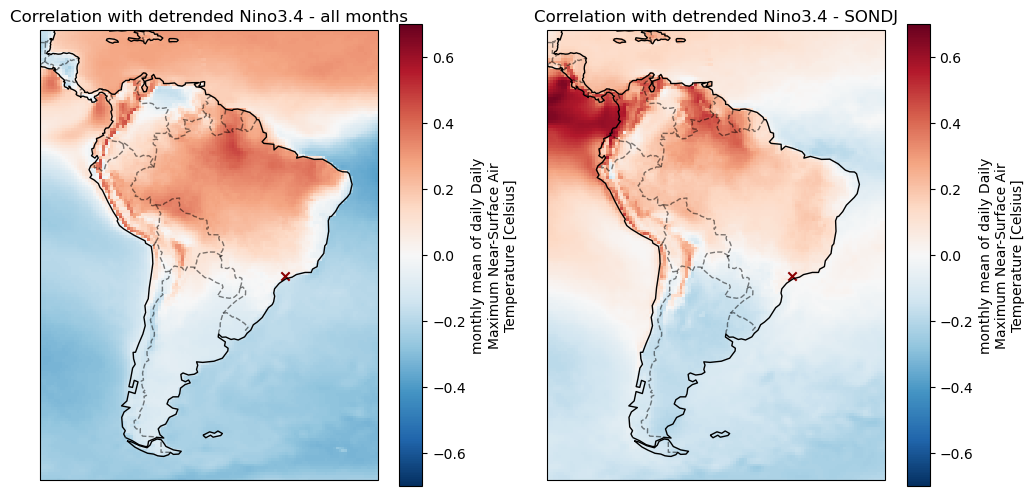

In [22]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)

plot_kwargs = {"vmin" : -0.7, "vmax" : 0.7, "cmap" : "RdBu_r"}

corr.plot(ax = axs[0], **plot_kwargs)
corr_sondj.plot(ax = axs[1], **plot_kwargs)

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    ax.scatter(*sp.values(), marker = "x", color = "darkred")
    
axs[0].set_title("Correlation with detrended Nino3.4 - all months")
axs[1].set_title("Correlation with detrended Nino3.4 - SONDJ")

plt.savefig("fig/corr_nino34rel-era5_SouthAmerica_allmonths.png")

### **Usual pattern of Nino3.4**

In [54]:
nino = decode_times(xr.open_dataset("data/iersst_nino3.4a.nc", decode_times = False))["Nino3.4"].to_dataframe()
nino_det = pd.read_csv("data/nino3.4_detrended.csv", index_col = "time", parse_dates = ["time"])

Text(0.5, 1.0, 'Detrended Nino3.4')

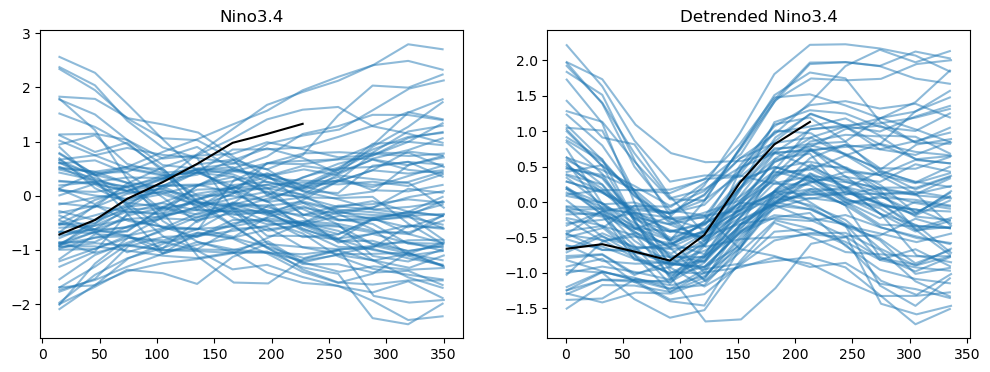

In [55]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

for y in range(1950, 2023):
    ts_y = nino.loc[str(y)]
    axs[0].plot(ts_y.index.day_of_year, ts_y, color = "tab:blue", alpha = 0.5)
ts_y = nino.loc["2023"]
axs[0].plot(ts_y.index.day_of_year, ts_y, color = "k")
axs[0].set_title("Nino3.4")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for y in range(1950, 2023):
    ts_y = nino_det.loc[str(y)]
    axs[1].plot(ts_y.index.day_of_year, ts_y, color = "tab:blue", alpha = 0.5)
ts_y = nino_det.loc["2023"]
axs[1].plot(ts_y.index.day_of_year, ts_y, color = "k")
axs[1].set_title("Detrended Nino3.4")

### **Create time series**

In [ ]:
import pandas as pd

In [32]:
ts = xr.open_dataset("data/CPC_tmax_daily01Jan1979-28Sep2023_ArgParBrazil.nc").tmax
ts_x = ts.rolling(time = 10).mean().sel(time = [m in [8,9] for m in ts.time.dt.month]).resample(time = "AS-JAN").max()

In [35]:
ts.rolling?

Signature:
ts.rolling(
    dim: 'Mapping[Any, int] | None' = None,
    min_periods: 'int | None' = None,
    center: 'bool | Mapping[Any, bool]' = False,
    **window_kwargs: 'int',
) -> 'DataArrayRolling'
Docstring:
Rolling window object for DataArrays.

Parameters
----------
dim : dict, optional
    Mapping from the dimension name to create the rolling iterator
    along (e.g. `time`) to its moving window size.
min_periods : int or None, default: None
    Minimum number of observations in window required to have a value
    (otherwise result is NA). The default, None, is equivalent to
    setting min_periods equal to the size of the window.
center : bool or Mapping to int, default: False
    Set the labels at the center of the window.
**window_kwargs : optional
    The keyword arguments form of ``dim``.
    One of dim or window_kwargs must be provided.

Returns
-------
core.rolling.DataArrayRolling

Examples
--------
Create rolling seasonal average of monthly data e.g. DJF, JFM, ...,

## **MODIS active fire data**


In [10]:
modis = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/fire_*_M-C61_*.csv")])
modis["y"] = [d.year for d in modis.acq_date]
modis["m"] = [d.month for d in modis.acq_date]
modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")

In [13]:
xn, xx, yn, yx = [-63,-41,-28,-11]

In [35]:
px = {k : get_latlon(k) for k in ["Bahia, BR", "Pantanal, BR", "Kanamari, BR"]}

In [36]:
px

{'Bahia, BR': {'lon': -41.9294776, 'lat': -12.285251},
 'Pantanal, BR': {'lon': -57.45533629711478, 'lat': -17.675068449999998},
 'Kanamari, BR': {'lon': -69.0642441887012, 'lat': -6.89874075}}

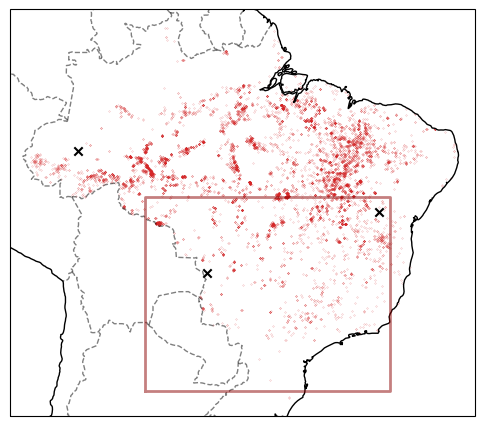

In [37]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (6,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
modis.loc[(modis.y == 2023) & (modis.m == 9) & (modis.confidence >= 95)].plot(ax = ax, marker = ".", color = "tab:red", alpha = 0.7, markersize = 0.1)
ax.coastlines()

ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

[ax.scatter(v["lon"], v["lat"], marker = "x", color = "k") for v in px.values()]

NameError: name 'px' is not defined

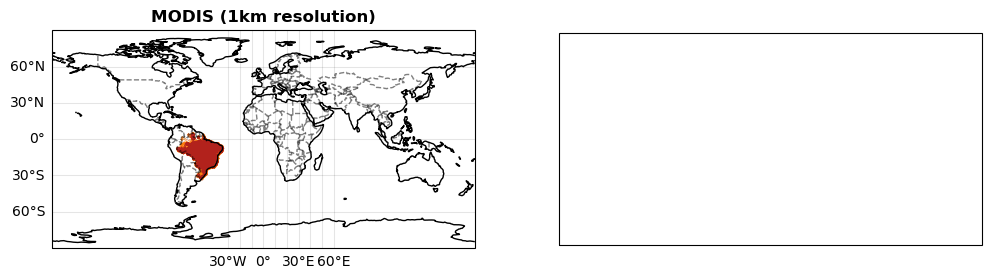

In [12]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)

modis.loc[(modis.y == 2023) & (modis.confidence >= 60) & ((modis["type"] == 0.0) | np.isnan(modis["type"]))].plot(ax = axs[0], marker = ".", color = "tab:orange", alpha = 0.7, markersize = 0.1)
modis.loc[(modis.y == 2023) & (modis.confidence >= 90) & ((modis["type"] == 0.0) | np.isnan(modis["type"]))].plot(ax = axs[0], marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
axs[0].set_title("MODIS (1km resolution)", fontweight = "bold")

for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-30,70,10))
    [ax.scatter(v["lon"], v["lat"], marker = "x", color = "k") for v in px.values()]
    [ax.annotate(k, xy = v.values(), fontweight = "bold", textcoords="offset points", xytext=(0,-12), ha='center') for k, v in px.items()]
    
    # ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)
    
plt.suptitle("Active fires in Brazil during 2023", fontweight = "bold", y = 0.93)

